In [ ]:
s!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
#Download your api kaggle.jdon from kaggle and upload it here
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lokadevm","key":"460dc02f59f07c98338841eab1442586"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 99% 657M/663M [00:15<00:00, 57.7MB/s]
100% 663M/663M [00:16<00:00, 43.4MB/s]


In [ ]:
#unziping the file
from zipfile import ZipFile
file_name = '/content/tuberculosis-tb-chest-xray-dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
! pip install split-folders


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Define paths
data_dir = '/content/TB_Chest_Radiography_Database'
normal_dir = os.path.join(data_dir, 'Normal')
tb_dir = os.path.join(data_dir, 'Tuberculosis')

# Load images and labels
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
images = normal_images + tb_images
labels = [0] * len(normal_images) + [1] * len(tb_images)  # 0 for normal, 1 for tuberculosis

# Resize and normalize images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to common size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values
    return img

# Preprocess all images
processed_images = [preprocess_image(img) for img in images]

# Split dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(processed_images, labels, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Shuffle and batch the datasets
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Count the number of samples in each dataset
train_count = len(train_images)
test_count = len(test_images)

# Print the number of samples in each dataset
print("Number of samples in the Train Dataset:", train_count)
print("Number of samples in the Test Dataset:", test_count)


Number of samples in the Train Dataset: 3360
Number of samples in the Test Dataset: 840


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define paths
data_dir = '/content/TB_Chest_Radiography_Database'
normal_dir = os.path.join(data_dir, 'Normal')
tb_dir = os.path.join(data_dir, 'Tuberculosis')

# Load images and labels
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
images = normal_images + tb_images
labels = [0] * len(normal_images) + [1] * len(tb_images)  # 0 for normal, 1 for tuberculosis

# Resize and normalize images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to common size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values
    return img

# Preprocess all images
processed_images = [preprocess_image(img) for img in images]

# Split dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(processed_images, labels, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Shuffle and batch the datasets
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Define ShuffleNetV2 model architecture
def create_ShuffleNetV2(input_shape, num_classes, learning_rate=0.001, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(24, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(48, (3, 3), strides=(1, 1), padding='same', groups=48, activation='relu'),
        layers.Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same', groups=96, activation='relu'),
        layers.Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same', groups=192, activation='relu'),
        layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 2  # 2 classes: Normal and Tuberculosis

# Define hyperparameters for tuning
learning_rates = [0.001, 0.0001]
dropout_rates = [0.5, 0.7]
epochs = 10
batch_size = 32
early_stopping_patience = 5  # Adjusted early stopping patience

best_model = None
best_accuracy = 0.0

# Perform hyperparameter tuning
for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        print(f"Training model with learning rate: {learning_rate}, dropout rate: {dropout_rate}")

        # Create the ShuffleNetV2 model
        model = create_ShuffleNetV2(input_shape, num_classes, learning_rate, dropout_rate)

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(filepath='shufflenetv2_best_model.h5', monitor='val_loss', save_best_only=True)

        # Train the model
        history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size,
                            validation_data=test_dataset, callbacks=[early_stopping, model_checkpoint])

        # Evaluate the model
        _, test_accuracy = model.evaluate(test_dataset)

        print(f"Test accuracy for current configuration: {test_accuracy}")

        # Check if current model is the best so far
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model

print("Hyperparameter tuning completed.")
print(f"Best test accuracy: {best_accuracy}")

# Save the best model
best_model.save('best_shufflenetv2_model.h5')


Training model with learning rate: 0.001, dropout rate: 0.5
Epoch 1/10
105/105 [==============================] - 17s 47ms/step - loss: 0.1111 - accuracy: 0.9598 - val_loss: 0.7535 - val_accuracy: 0.1631
Epoch 2/10
  3/105 [..............................] - ETA: 3s - loss: 0.0162 - accuracy: 0.9896

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


105/105 [==============================] - 4s 37ms/step - loss: 0.0751 - accuracy: 0.9744 - val_loss: 0.7537 - val_accuracy: 0.1631
Epoch 3/10
105/105 [==============================] - 3s 33ms/step - loss: 0.0557 - accuracy: 0.9848 - val_loss: 1.0012 - val_accuracy: 0.1631
Epoch 4/10
105/105 [==============================] - 4s 33ms/step - loss: 0.0330 - accuracy: 0.9902 - val_loss: 1.3558 - val_accuracy: 0.1631
Epoch 5/10
105/105 [==============================] - 4s 35ms/step - loss: 0.0431 - accuracy: 0.9875 - val_loss: 1.7968 - val_accuracy: 0.1655
Epoch 6/10
105/105 [==============================] - 4s 35ms/step - loss: 0.0262 - accuracy: 0.9935 - val_loss: 0.6043 - val_accuracy: 0.8548
Epoch 7/10
105/105 [==============================] - 4s 36ms/step - loss: 0.0598 - accuracy: 0.9881 - val_loss: 24.0814 - val_accuracy: 0.1714
Epoch 8/10
105/105 [==============================] - 4s 34ms/step - loss: 0.0953 - accuracy: 0.9821 - val_loss: 3.6652 - val_accuracy: 0.8429
Epoch 9/1

27/27 [==============================] - 3s 51ms/step
Accuracy: 0.9833333333333333
Precision: 0.9624060150375939
Recall: 0.9343065693430657
Sensitivity: 0.9343065693430657


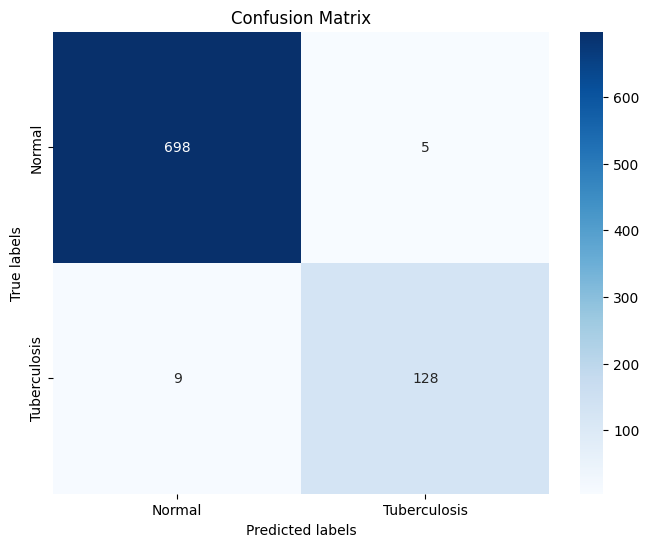

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       703
Tuberculosis       0.96      0.93      0.95       137

    accuracy                           0.98       840
   macro avg       0.97      0.96      0.97       840
weighted avg       0.98      0.98      0.98       840



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_shufflenetv2_model.h5')

# Predict on the test dataset
y_pred = np.argmax(best_model.predict(test_dataset), axis=-1)

# Get true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate performance metrics
accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1, 1] / np.sum(cm[:, 1])
recall = cm[1, 1] / np.sum(cm[1, :])
sensitivity = recall

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Sensitivity:", sensitivity)

# Generate a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Tuberculosis"], yticklabels=["Normal", "Tuberculosis"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
print(classification_report(y_true, y_pred, target_names=["Normal", "Tuberculosis"]))


27/27 [==============================] - 2s 35ms/step
Accuracy: 0.9940476190476191
Precision: 0.9852941176470589
Recall: 0.9781021897810219
Sensitivity: 0.9781021897810219


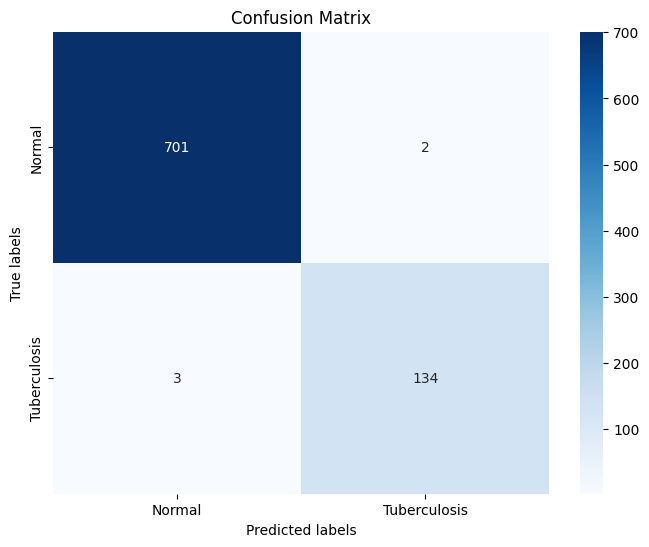

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       703
Tuberculosis       0.99      0.98      0.98       137

    accuracy                           0.99       840
   macro avg       0.99      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_shufflenetv2_model.h5')

# Predict on the test dataset
y_pred = np.argmax(best_model.predict(test_dataset), axis=-1)

# Get true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate performance metrics
accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1, 1] / np.sum(cm[:, 1])
recall = cm[1, 1] / np.sum(cm[1, :])
sensitivity = recall

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Sensitivity:", sensitivity)

# Generate a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Tuberculosis"], yticklabels=["Normal", "Tuberculosis"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
print(classification_report(y_true, y_pred, target_names=["Normal", "Tuberculosis"]))


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define paths
data_dir = '/content/TB_Chest_Radiography_Database'
normal_dir = os.path.join(data_dir, 'Normal')
tb_dir = os.path.join(data_dir, 'Tuberculosis')

# Load images and labels
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
images = normal_images + tb_images
labels = [0] * len(normal_images) + [1] * len(tb_images)  # 0 for normal, 1 for tuberculosis

# Resize and normalize images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to common size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values
    return img

# Preprocess all images
processed_images = [preprocess_image(img) for img in images]

# Split dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(processed_images, labels, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Shuffle and batch the datasets
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Define ShuffleNetV2 model architecture
def create_ShuffleNetV2(input_shape, num_classes, learning_rate=0.001, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(24, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(48, (3, 3), strides=(1, 1), padding='same', groups=48, activation='relu'),
        layers.Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same', groups=96, activation='relu'),
        layers.Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same', groups=192, activation='relu'),
        layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 2  # 2 classes: Normal and Tuberculosis

# Define hyperparameters for tuning
learning_rates = [0.001, 0.0001]
dropout_rates = [0.5, 0.7]
epochs = 10
batch_size = 32
early_stopping_patience = 5  # Adjusted early stopping patience

best_model = None
best_accuracy = 0.0

# Perform hyperparameter tuning
for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        print(f"Training model with learning rate: {learning_rate}, dropout rate: {dropout_rate}")

        # Create the ShuffleNetV2 model
        model = create_ShuffleNetV2(input_shape, num_classes, learning_rate, dropout_rate)

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(filepath='shufflenetv2_best_model.h5', monitor='val_loss', save_best_only=True)

        # Train the model
        history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size,
                            validation_data=test_dataset, callbacks=[early_stopping, model_checkpoint])

        # Evaluate the model
        _, test_accuracy = model.evaluate(test_dataset)

        print(f"Test accuracy for current configuration: {test_accuracy}")

        # Check if current model is the best so far
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model

print("Hyperparameter tuning completed.")
print(f"Best test accuracy: {best_accuracy}")

# Save the best model
best_model.save('best_shufflenetv2_model.h5')


Training model with learning rate: 0.001, dropout rate: 0.5
Epoch 1/10
105/105 [==============================] - 17s 48ms/step - loss: 0.1637 - accuracy: 0.9461 - val_loss: 0.8020 - val_accuracy: 0.1631
Epoch 2/10
  3/105 [..............................] - ETA: 2s - loss: 0.1145 - accuracy: 0.9688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


105/105 [==============================] - 4s 36ms/step - loss: 0.0521 - accuracy: 0.9827 - val_loss: 0.8568 - val_accuracy: 0.1631
Epoch 3/10
105/105 [==============================] - 4s 34ms/step - loss: 0.0423 - accuracy: 0.9869 - val_loss: 1.0916 - val_accuracy: 0.1631
Epoch 4/10
105/105 [==============================] - 4s 33ms/step - loss: 0.0544 - accuracy: 0.9821 - val_loss: 2.1838 - val_accuracy: 0.1631
Epoch 5/10
105/105 [==============================] - 4s 37ms/step - loss: 0.0476 - accuracy: 0.9851 - val_loss: 1.9658 - val_accuracy: 0.2726
Epoch 6/10
105/105 [==============================] - 4s 36ms/step - loss: 0.0255 - accuracy: 0.9940 - val_loss: 0.2261 - val_accuracy: 0.8964
Epoch 7/10
105/105 [==============================] - 4s 34ms/step - loss: 0.0255 - accuracy: 0.9923 - val_loss: 0.4579 - val_accuracy: 0.8643
Epoch 8/10
105/105 [==============================] - 4s 38ms/step - loss: 0.0616 - accuracy: 0.9827 - val_loss: 0.1511 - val_accuracy: 0.9702
Epoch 9/10

27/27 [==============================] - 2s 34ms/step
Accuracy: 0.9845238095238096
Precision: 0.9366197183098591
Recall: 0.9708029197080292
Sensitivity: 0.9708029197080292


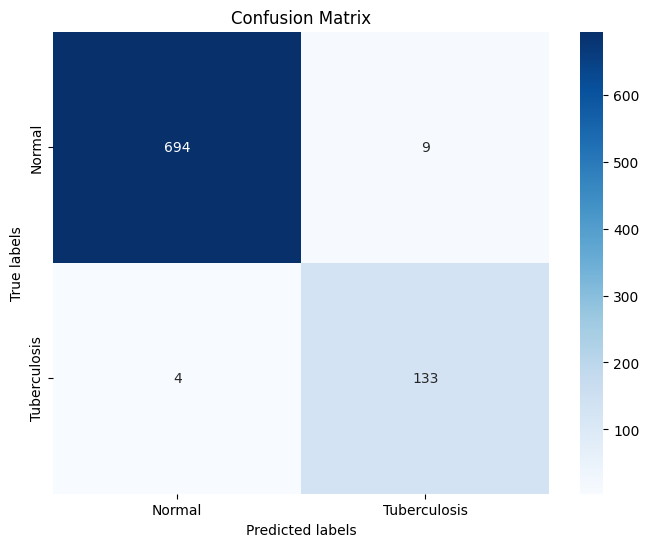

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       703
Tuberculosis       0.94      0.97      0.95       137

    accuracy                           0.98       840
   macro avg       0.97      0.98      0.97       840
weighted avg       0.98      0.98      0.98       840



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_shufflenetv2_model.h5')

# Predict on the test dataset
y_pred = np.argmax(best_model.predict(test_dataset), axis=-1)

# Get true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate performance metrics
accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1, 1] / np.sum(cm[:, 1])
recall = cm[1, 1] / np.sum(cm[1, :])
sensitivity = recall

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Sensitivity:", sensitivity)

# Generate a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Tuberculosis"], yticklabels=["Normal", "Tuberculosis"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
print(classification_report(y_true, y_pred, target_names=["Normal", "Tuberculosis"]))


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define paths
data_dir = '/content/TB_Chest_Radiography_Database'
normal_dir = os.path.join(data_dir, 'Normal')
tb_dir = os.path.join(data_dir, 'Tuberculosis')

# Load images and labels
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
images = normal_images + tb_images
labels = [0] * len(normal_images) + [1] * len(tb_images)  # 0 for normal, 1 for tuberculosis

# Resize and normalize images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to common size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values
    return img

# Preprocess all images
processed_images = [preprocess_image(img) for img in images]

# Split dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(processed_images, labels, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Shuffle and batch the datasets
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Define ShuffleNetV2 model architecture
def create_ShuffleNetV2(input_shape, num_classes, learning_rate=0.001, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(24, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(48, (3, 3), strides=(1, 1), padding='same', groups=48, activation='relu'),
        layers.Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same', groups=96, activation='relu'),
        layers.Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same', groups=192, activation='relu'),
        layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 2  # 2 classes: Normal and Tuberculosis

# Set fixed hyperparameters
learning_rate = 0.001
dropout_rate = 0.5
epochs = 10
batch_size = 32
early_stopping_patience = 5

# Create the ShuffleNetV2 model
model = create_ShuffleNetV2(input_shape, num_classes, learning_rate, dropout_rate)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='shufflenetv2_best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size,
                    validation_data=test_dataset, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
_, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")

# Save the best model
model.save('best_shufflenetv2_model.h5')


Epoch 1/10
105/105 [==============================] - 201s 2s/step - loss: 0.1231 - accuracy: 0.9604 - val_loss: 0.7559 - val_accuracy: 0.1631


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
105/105 [==============================] - 193s 2s/step - loss: 0.0487 - accuracy: 0.9830 - val_loss: 0.8762 - val_accuracy: 0.1631
Epoch 3/10
105/105 [==============================] - 192s 2s/step - loss: 0.0411 - accuracy: 0.9863 - val_loss: 0.8758 - val_accuracy: 0.1631
Epoch 4/10
105/105 [==============================] - 190s 2s/step - loss: 0.0412 - accuracy: 0.9872 - val_loss: 1.2434 - val_accuracy: 0.1631
Epoch 5/10
105/105 [==============================] - 190s 2s/step - loss: 0.0385 - accuracy: 0.9878 - val_loss: 0.2280 - val_accuracy: 0.9369
Epoch 6/10
105/105 [==============================] - 189s 2s/step - loss: 0.0386 - accuracy: 0.9887 - val_loss: 0.5771 - val_accuracy: 0.7655
Epoch 7/10
105/105 [==============================] - 190s 2s/step - loss: 0.0369 - accuracy: 0.9893 - val_loss: 0.9004 - val_accuracy: 0.8845
Epoch 8/10
105/105 [==============================] - 190s 2s/step - loss: 0.0415 - accuracy: 0.9908 - val_loss: 0.0881 - val_accuracy: 0.9762

27/27 [==============================] - 18s 654ms/step
Accuracy: 0.5488095238095239
Precision: 0.2655038759689923
Recall: 1.0
Sensitivity: 1.0


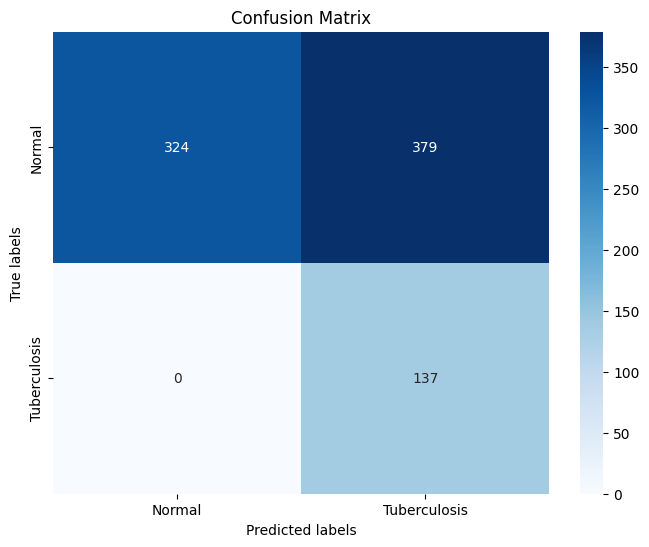

              precision    recall  f1-score   support

      Normal       1.00      0.46      0.63       703
Tuberculosis       0.27      1.00      0.42       137

    accuracy                           0.55       840
   macro avg       0.63      0.73      0.53       840
weighted avg       0.88      0.55      0.60       840



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_shufflenetv2_model.h5')

# Predict on the test dataset
y_pred = np.argmax(best_model.predict(test_dataset), axis=-1)

# Get true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate performance metrics
accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1, 1] / np.sum(cm[:, 1])
recall = cm[1, 1] / np.sum(cm[1, :])
sensitivity = recall

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Sensitivity:", sensitivity)

# Generate a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Tuberculosis"], yticklabels=["Normal", "Tuberculosis"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
print(classification_report(y_true, y_pred, target_names=["Normal", "Tuberculosis"]))


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Define paths
data_dir = '/content/TB_Chest_Radiography_Database'
normal_dir = os.path.join(data_dir, 'Normal')
tb_dir = os.path.join(data_dir, 'Tuberculosis')

# Load images and labels
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
images = normal_images + tb_images
labels = [0] * len(normal_images) + [1] * len(tb_images)  # 0 for normal, 1 for tuberculosis

# Resize and normalize images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to common size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values
    return img

# Preprocess all images
processed_images = [preprocess_image(img) for img in images]

# Split dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(processed_images, labels, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dataset = datagen.flow(np.array(train_images), np.array(train_labels), batch_size=32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

# Define ShuffleNetV2 model architecture
def create_ShuffleNetV2(input_shape, num_classes, learning_rate=0.001, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(24, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        layers.Conv2D(48, (3, 3), strides=(1, 1), padding='same', groups=48, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same', groups=96, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same', groups=192, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 2  # 2 classes: Normal and Tuberculosis

# Set fixed hyperparameters
learning_rate = 0.001
dropout_rate = 0.5
epochs = 10
batch_size = 32
early_stopping_patience = 5

# Create the ShuffleNetV2 model
model = create_ShuffleNetV2(input_shape, num_classes, learning_rate, dropout_rate)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='shufflenetv2_best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Evaluate the model
_, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")

# Save the best model
model.save('best_shufflenetv2_model.h5')


Epoch 1/10
105/105 [==============================] - 225s 2s/step - loss: 0.7545 - accuracy: 0.9232 - val_loss: 1.1772 - val_accuracy: 0.1631 - lr: 0.0010
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


105/105 [==============================] - 221s 2s/step - loss: 0.5816 - accuracy: 0.9408 - val_loss: 1.1523 - val_accuracy: 0.1631 - lr: 0.0010
Epoch 3/10
105/105 [==============================] - 217s 2s/step - loss: 0.4851 - accuracy: 0.9536 - val_loss: 1.2448 - val_accuracy: 0.1631 - lr: 0.0010
Epoch 4/10
105/105 [==============================] - 217s 2s/step - loss: 0.4243 - accuracy: 0.9518 - val_loss: 1.3031 - val_accuracy: 0.1631 - lr: 0.0010
Epoch 5/10
105/105 [==============================] - 212s 2s/step - loss: 0.3645 - accuracy: 0.9628 - val_loss: 1.1079 - val_accuracy: 0.2071 - lr: 0.0010
Epoch 6/10
105/105 [==============================] - 213s 2s/step - loss: 0.3243 - accuracy: 0.9634 - val_loss: 1.3947 - val_accuracy: 0.2940 - lr: 0.0010
Epoch 7/10
105/105 [==============================] - 212s 2s/step - loss: 0.2821 - accuracy: 0.9723 - val_loss: 0.2407 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 8/10
105/105 [==============================] - 213s 2s/step - loss: 

27/27 [==============================] - 18s 618ms/step
Accuracy: 0.9833333333333333
Precision: 0.9694656488549618
Recall: 0.927007299270073
Sensitivity: 0.927007299270073


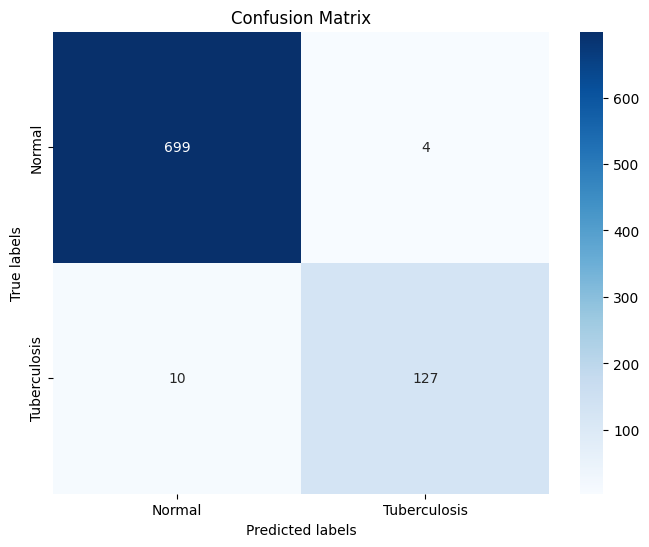

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       703
Tuberculosis       0.97      0.93      0.95       137

    accuracy                           0.98       840
   macro avg       0.98      0.96      0.97       840
weighted avg       0.98      0.98      0.98       840



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_shufflenetv2_model.h5')

# Predict on the test dataset
y_pred = np.argmax(best_model.predict(test_dataset), axis=-1)

# Get true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate performance metrics
accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1, 1] / np.sum(cm[:, 1])
recall = cm[1, 1] / np.sum(cm[1, :])
sensitivity = recall

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Sensitivity:", sensitivity)

# Generate a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Tuberculosis"], yticklabels=["Normal", "Tuberculosis"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
print(classification_report(y_true, y_pred, target_names=["Normal", "Tuberculosis"]))


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.spatial import distance_matrix

# Define paths
data_dir = '/content/TB_Chest_Radiography_Database'
normal_dir = os.path.join(data_dir, 'Normal')
tb_dir = os.path.join(data_dir, 'Tuberculosis')

# Load images and labels
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
images = normal_images + tb_images
labels = [0] * len(normal_images) + [1] * len(tb_images)  # 0 for normal, 1 for tuberculosis

# Resize and normalize images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to common size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values
    return img

# Preprocess all images
processed_images = [preprocess_image(img) for img in images]

# Split dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(processed_images, labels, test_size=0.2, random_state=42)

# Function to create a graph convolutional layer
class GraphConvLayer(layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(GraphConvLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[0][-1], self.units),
                                      initializer='glorot_uniform',
                                      name='kernel')
        self.bias = self.add_weight(shape=(self.units,),
                                    initializer='zeros',
                                    name='bias')

    def call(self, inputs):
        X, A = inputs
        support = tf.matmul(X, self.kernel)
        output = tf.matmul(A, support)
        output = tf.nn.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

# Create a GCN model
def create_GCN(input_shape, num_classes, learning_rate=0.001, dropout_rate=0.5):
    X_in = layers.Input(shape=input_shape)
    A_in = layers.Input(shape=(input_shape[0],))

    X = GraphConvLayer(32, activation='relu')([X_in, A_in])
    X = layers.Dropout(dropout_rate)(X)
    X = GraphConvLayer(16, activation='relu')([X, A_in])
    X = layers.Dropout(dropout_rate)(X)
    X = layers.GlobalAveragePooling1D()(X)
    X = layers.Dense(num_classes, activation='softmax')(X)

    model = models.Model(inputs=[X_in, A_in], outputs=X)

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to create k-NN graph
def create_knn_graph(X, k=5):
    D = distance_matrix(X, X)
    A = np.zeros_like(D)
    for i in range(X.shape[0]):
        neighbors = np.argsort(D[i])[:k+1]
        A[i, neighbors] = 1
    return A

# Convert images to graph data
def images_to_graph_data(images):
    graph_data = []
    for img in images:
        patches = tf.image.extract_patches(
            images=tf.expand_dims(img, 0),
            sizes=[1, 32, 32, 1],
            strides=[1, 32, 32, 1],
            rates=[1, 1, 1, 1],
            padding='SAME'
        )
        patches = tf.reshape(patches, (-1, 32*32*3))
        A = create_knn_graph(patches.numpy())
        graph_data.append((patches.numpy(), A))
    return graph_data

# Convert images to graph data
train_graph_data = images_to_graph_data(train_images)
test_graph_data = images_to_graph_data(test_images)

train_graph_X = np.array([data[0] for data in train_graph_data])
train_graph_A = np.array([data[1] for data in train_graph_data])
test_graph_X = np.array([data[0] for data in test_graph_data])
test_graph_A = np.array([data[1] for data in test_graph_data])

# Define input shape and number of classes
input_shape = train_graph_X.shape[1:]
num_classes = 2  # 2 classes: Normal and Tuberculosis

# Define hyperparameters for tuning
learning_rates = [0.001, 0.0001]
dropout_rates = [0.5, 0.7]
epochs = 10
batch_size = 32
early_stopping_patience = 5  # Adjusted early stopping patience

best_model = None
best_accuracy = 0.0

# Perform hyperparameter tuning
for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        print(f"Training model with learning rate: {learning_rate}, dropout rate: {dropout_rate}")

        # Create the GCN model
        model = create_GCN(input_shape, num_classes, learning_rate, dropout_rate)

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(filepath='gcn_best_model.h5', monitor='val_loss', save_best_only=True)

        # Train the model
        history = model.fit(
            x=[train_graph_X, train_graph_A], y=np.array(train_labels),
            validation_data=([test_graph_X, test_graph_A], np.array(test_labels)),
            epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, model_checkpoint])

        # Evaluate the model
        _, test_accuracy = model.evaluate([test_graph_X, test_graph_A], np.array(test_labels))

        print(f"Test accuracy for current configuration: {test_accuracy}")

        # Check if current model is the best so far
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model

print("Hyperparameter tuning completed.")
print(f"Best test accuracy: {best_accuracy}")

# Save the best model
best_model.save('best_gcn_model.h5')


Training model with learning rate: 0.001, dropout rate: 0.5


In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import streamlit as st

# Function to preprocess image
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    return img

# Function to create ShuffleNetV2 model
def create_ShuffleNetV2(input_shape, num_classes, learning_rate=0.001, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(24, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(48, (3, 3), strides=(1, 1), padding='same', groups=48, activation='relu'),
        layers.Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same', groups=96, activation='relu'),
        layers.Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same', groups=192, activation='relu'),
        layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Main Streamlit app
st.title('TB Chest Radiography Classification')

# File uploader for dataset
data_dir = st.text_input('Enter the path to the dataset:', '/content/TB_Chest_Radiography_Database')
if st.button('Load Data'):
    normal_dir = os.path.join(data_dir, 'Normal')
    tb_dir = os.path.join(data_dir, 'Tuberculosis')

    normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
    tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
    images = normal_images + tb_images
    labels = [0] * len(normal_images) + [1] * len(tb_images)

    processed_images = [preprocess_image(img) for img in images]
    train_images, test_images, train_labels, test_labels = train_test_split(processed_images, labels, test_size=0.2, random_state=42)

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

    BATCH_SIZE = 32
    train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)

    st.write('Data loaded successfully!')

# Model training parameters
learning_rate = st.selectbox('Select learning rate:', [0.001, 0.0001])
dropout_rate = st.selectbox('Select dropout rate:', [0.5, 0.7])
epochs = st.number_input('Enter number of epochs:', min_value=1, value=10)
early_stopping_patience = st.number_input('Enter early stopping patience:', min_value=1, value=5)

if st.button('Train Model'):
    best_model = None
    best_accuracy = 0.0

    st.write(f"Training model with learning rate: {learning_rate}, dropout rate: {dropout_rate}")

    model = create_ShuffleNetV2((224, 224, 3), 2, learning_rate, dropout_rate)

    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(filepath='shufflenetv2_best_model.h5', monitor='val_loss', save_best_only=True)

    history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[early_stopping, model_checkpoint])

    _, test_accuracy = model.evaluate(test_dataset)
    st.write(f"Test accuracy for current configuration: {test_accuracy}")

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model

    st.write(f"Best test accuracy: {best_accuracy}")

    best_model.save('best_shufflenetv2_model.h5')
    st.write("Model saved as 'best_shufflenetv2_model.h5'")

if st.button('Download Best Model'):
    with open('best_shufflenetv2_model.h5', 'rb') as f:
        st.download_button('Download Model', f, file_name='best_shufflenetv2_model.h5')


2024-05-20 06:53:19.364 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-05-20 06:53:19.366 Session state does not function when running a script without `streamlit run`


In [ ]:
if st.button('Download Best Model'):
    with open('best_shufflenetv2_model.h5', 'rb') as f:
        st.download_button('Download Model', f, file_name='best_shufflenetv2_model.h5')


In [ ]:
streamlit run best_shufflenetv2_model.py


SyntaxError: invalid syntax (<ipython-input-12-b70af758f6e8>, line 1)

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import streamlit as st

# Function to preprocess image
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    return img

# Function to create ShuffleNetV2 model
def create_ShuffleNetV2(input_shape, num_classes, learning_rate=0.001, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(24, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(48, (3, 3), strides=(1, 1), padding='same', groups=48, activation='relu'),
        layers.Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same', groups=96, activation='relu'),
        layers.Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same', groups=192, activation='relu'),
        layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Main Streamlit app
st.title('TB Chest Radiography Classification')

# File uploader for dataset
data_dir = st.text_input('Enter the path to the dataset:', '/content/TB_Chest_Radiography_Database')
if st.button('Load Data'):
    normal_dir = os.path.join(data_dir, 'Normal')
    tb_dir = os.path.join(data_dir, 'Tuberculosis')

    normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
    tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
    images = normal_images + tb_images
    labels = [0] * len(normal_images) + [1] * len(tb_images)

    processed_images = [preprocess_image(img) for img in images]
    train_images, test_images, train_labels, test_labels = train_test_split(processed_images, labels, test_size=0.2, random_state=42)

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

    BATCH_SIZE = 32
    train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)

    st.write('Data loaded successfully!')

# Model training parameters
learning_rate = st.selectbox('Select learning rate:', [0.001, 0.0001])
dropout_rate = st.selectbox('Select dropout rate:', [0.5, 0.7])
epochs = st.number_input('Enter number of epochs:', min_value=1, value=10)
early_stopping_patience = st.number_input('Enter early stopping patience:', min_value=1, value=5)

if st.button('Train Model'):
    best_model = None
    best_accuracy = 0.0

    st.write(f"Training model with learning rate: {learning_rate}, dropout rate: {dropout_rate}")

    model = create_ShuffleNetV2((224, 224, 3), 2, learning_rate, dropout_rate)

    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(filepath='shufflenetv2_best_model.h5', monitor='val_loss', save_best_only=True)

    history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[early_stopping, model_checkpoint])

    _, test_accuracy = model.evaluate(test_dataset)
    st.write(f"Test accuracy for current configuration: {test_accuracy}")

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model

    st.write(f"Best test accuracy: {best_accuracy}")

    best_model.save('best_shufflenetv2_model.h5')
    st.write("Model saved as 'best_shufflenetv2_model.h5'")

if st.button('Download Best Model'):
    with open('best_shufflenetv2_model.h5', 'rb') as f:
        st.download_button('Download Model', f, file_name='best_shufflenetv2_model.h5')


In [ ]:
!streamlit run shufflenetv2.ipynb



Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Streamlit requires raw Python (.py) files, not .ipynb.
For more information, please see https://docs.streamlit.io


In [ ]:
pip install tensorflow opencv-python-headless streamlit


In [ ]:
!pip install streamlit pyngrok opencv-python-headless

with open('app.py', 'w') as f:
    f.write("""
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import streamlit as st

# Function to preprocess image
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    return img

# Function to create ShuffleNetV2 model
def create_ShuffleNetV2(input_shape, num_classes, learning_rate=0.001, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(24, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(48, (3, 3), strides=(1, 1), padding='same', groups=48, activation='relu'),
        layers.Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same', groups=96, activation='relu'),
        layers.Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same', groups=192, activation='relu'),
        layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Main Streamlit app
st.title('TB Chest Radiography Classification')

# File uploader for dataset
data_dir = st.text_input('Enter the path to the dataset:', '/content/TB_Chest_Radiography_Database')
if st.button('Load Data'):
    normal_dir = os.path.join(data_dir, 'Normal')
    tb_dir = os.path.join(data_dir, 'Tuberculosis')

    normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
    tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
    images = normal_images + tb_images
    labels = [0] * len(normal_images) + [1] * len(tb_images)

    processed_images = [preprocess_image(img) for img in images]
    train_images, test_images, train_labels, test_labels = train_test_split(processed_images, labels, test_size=0.2, random_state=42)

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

    BATCH_SIZE = 32
    train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)

    st.write('Data loaded successfully!')

# Model training parameters
learning_rate = st.selectbox('Select learning rate:', [0.001, 0.0001])
dropout_rate = st.selectbox('Select dropout rate:', [0.5, 0.7])
epochs = st.number_input('Enter number of epochs:', min_value=1, value=10)
early_stopping_patience = st.number_input('Enter early stopping patience:', min_value=1, value=5)

if st.button('Train Model'):
    best_model = None
    best_accuracy = 0.0

    st.write(f"Training model with learning rate: {learning_rate}, dropout rate: {dropout_rate}")

    model = create_ShuffleNetV2((224, 224, 3), 2, learning_rate, dropout_rate)

    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(filepath='shufflenetv2_best_model.h5', monitor='val_loss', save_best_only=True)

    history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[early_stopping, model_checkpoint])

    _, test_accuracy = model.evaluate(test_dataset)
    st.write(f"Test accuracy for current configuration: {test_accuracy}")

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model

    st.write(f"Best test accuracy: {best_accuracy}")

    best_model.save('best_shufflenetv2_model.h5')
    st.write("Model saved as 'best_shufflenetv2_model.h5'")

if st.button('Download Best Model'):
    with open('best_shufflenetv2_model.h5', 'rb') as f:
        st.download_button('Download Model', f, file_name='best_shufflenetv2_model.h5')
    """)

from pyngrok import ngrok

# Terminate any existing tunnels
ngrok.kill()

# Create a new ngrok tunnel
public_url = ngrok.connect(port='8501')
print(f"Streamlit app is live at: {public_url}")

!streamlit run app.py &


ERROR:pyngrok.process.ngrok:t=2024-05-20T07:22:12+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-05-20T07:22:12+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-05-20T07:22:12+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

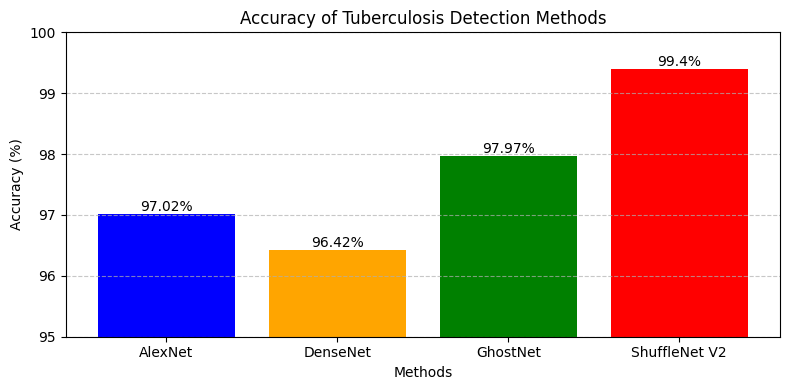

In [ ]:
import matplotlib.pyplot as plt

# Method names and corresponding accuracies
methods = ['AlexNet', 'DenseNet', 'GhostNet', 'ShuffleNet V2']
accuracies = [97.02, 96.42, 97.97, 99.40]  # Accuracies in percentage

# Create bar graph
plt.figure(figsize=(8, 4))
plt.bar(methods, accuracies, color=['blue', 'orange', 'green', 'red'])

# Add title and labels
plt.title('Accuracy of Tuberculosis Detection Methods')
plt.xlabel('Methods')
plt.ylabel('Accuracy (%)')

# Add accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{acc}%', ha='center', va='bottom')

# Show plot
plt.ylim(95, 100)  # Set y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
